In [11]:
import numpy as np
import h5py
import scipy.fftpack
import csv
import pylab as pl
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import transforms, colors
import os
import glob


from scipy.optimize import curve_fit
from scipy.optimize import fsolve

#%matplotlib notebook
%matplotlib inline

pl.rcParams['figure.figsize']  = 15, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 25

pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [8]:
import PetscBinaryIO

import domain
import boundary_conditions
import params
import initialize

In [9]:
N_q1 = domain.N_q1
N_q2 = domain.N_q2

q1 = domain.q1_start + (0.5 + np.arange(N_q1)) * (domain.q1_end - domain.q1_start)/N_q1
q2 = domain.q2_start + (0.5 + np.arange(N_q2)) * (domain.q2_end - domain.q2_start)/N_q2

q2_meshgrid, q1_meshgrid = np.meshgrid(q2, q1)

source_start = params.contact_start
source_end   = params.contact_end

drain_start  = params.contact_start
drain_end    = params.contact_end

source_indices =  (q2 > source_start) & (q2 < source_end)
drain_indices  =  (q2 > drain_start)  & (q2 < drain_end )

io = PetscBinaryIO.PetscBinaryIO()

filepath = os.getcwd()
moment_files 		  = np.sort(glob.glob(filepath+'/dump_moments/*.bin'))
lagrange_multiplier_files = \
        np.sort(glob.glob(filepath+'/dump_lagrange_multipliers/*.bin'))

dt = params.dt

#time_array = params.dt_dump_moments * np.arange(0, moment_files.size, 1)
time_array = params.dt_dump_moments*np.arange(0, moment_files.size, 1)

file_number = 0
moments = io.readBinaryFile(moment_files[file_number])
moments = moments[0].reshape(N_q2, N_q1, 3)

density_bg = moments[:, :, 0]


dx = q1[1] - q1[0]
dy = q2[1] - q2[0]

In [12]:
emitter_voltage_array   = []
collector_voltage_array = []

print("Reading sensor signal...")
for file_number, dump_file in enumerate(moment_files):
#    file_number = -1
    moments = io.readBinaryFile(moment_files[file_number])
    moments = moments[0].reshape(N_q2, N_q1, 3)
    
    density = moments[:, :, 0]
    density = density - density_bg
    
    lagrange_multipliers = \
            io.readBinaryFile(lagrange_multiplier_files[file_number])
    lagrange_multipliers = lagrange_multipliers[0].reshape(N_q2, N_q1, 5)
        
    vel_drift_x  = lagrange_multipliers[:, :, 3]
    vel_drift_y  = lagrange_multipliers[:, :, 4]
    
    emitter_indices   = q2 < 1
    collector_indices = q2 < 1.

    emitter_voltage   = np.mean(density[emitter_indices,   0])
    collector_voltage = np.mean(density[collector_indices, -1])

    emitter_voltage_array.append(emitter_voltage)
    collector_voltage_array.append(collector_voltage)
    

emitter_voltage_array   = np.array(emitter_voltage_array)
collector_voltage_array = np.array(collector_voltage_array)

Reading sensor signal...


Text(0.5, 0, 'Time (ps)')

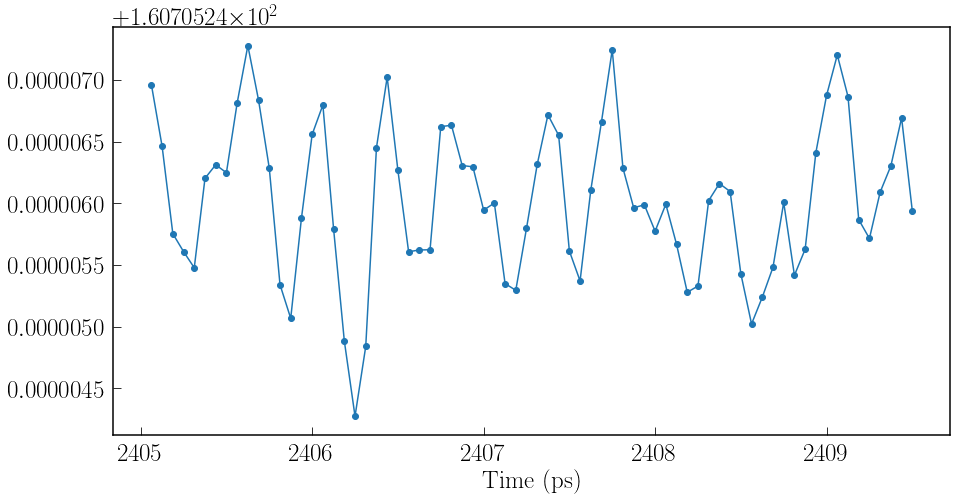

In [15]:
time_index = time_array > 2405

pl.plot(time_array[time_index], (emitter_voltage_array-collector_voltage_array)[time_index], '-o')
#pl.plot(time_array[time_index], collector_voltage_array[time_index])

#pl.axhline(0, color='black', linestyle='--')


pl.xlabel(r'Time (ps)')

#pl.suptitle('$\\tau_\mathrm{mc} = 0.2$ ps, $\\tau_\mathrm{mr} = 0.5$ ps')
#pl.savefig('images/iv' + '.png')
#pl.clf()

In [18]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or pl.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

class MidpointNormalize (colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
    # I'm ignoring masked values and all kinds of edge cases to make
    # a simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

x.shape :  (200, 50)


Text(0, 0.5, '$y\\;(\\mu \\mathrm{m})$')

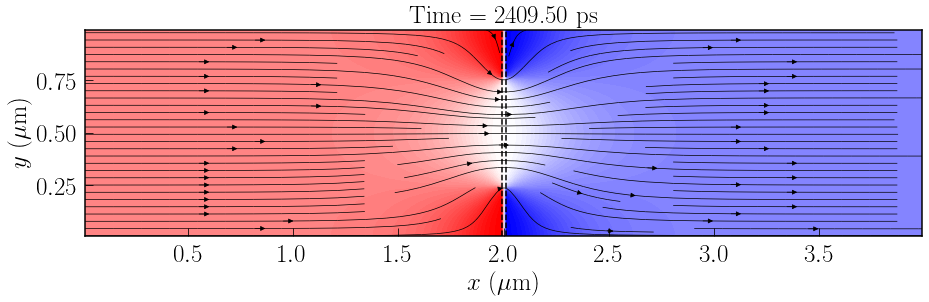

In [30]:
coords = io.readBinaryFile("coords.bin")
coords = coords[0].reshape(N_q2, N_q1, 13)
    
x = coords[:, :, 0].T
y = coords[:, :, 1].T

start_index = 0
file_number = -1

moments = io.readBinaryFile(moment_files[start_index+file_number])
moments = moments[0].reshape(N_q2, N_q1, 3)

density = moments[:, :, 0]
j_x     = moments[:, :, 1]
j_y     = moments[:, :, 2]

lagrange_multipliers = \
    io.readBinaryFile(lagrange_multiplier_files[start_index+file_number])
lagrange_multipliers = lagrange_multipliers[0].reshape(N_q2, N_q1, 5)

mu           = lagrange_multipliers[:, :, 0]
mu_ee        = lagrange_multipliers[:, :, 1]
T_ee         = lagrange_multipliers[:, :, 2]
vel_drift_x  = lagrange_multipliers[:, :, 3]
vel_drift_y  = lagrange_multipliers[:, :, 4]

density = density - density_bg
density_min = np.min(density)
density_max = np.max(density)

print ("x.shape : ", x.shape)    

#plot_grid(x[::5, ::5], y[::5, ::5], alpha=0.5)
pl.contourf(x, y, density.T, 100, norm=MidpointNormalize(midpoint=0, vmin=density_min, vmax=density_max), cmap='bwr')
#pl.colorbar()
pl.title(r'Time = ' + "%.2f"%(time_array[start_index+file_number]) + " ps")

pl.streamplot(x[:, 0], y[0, :], 
              vel_drift_x, vel_drift_y,
              density=1, color='k',
              linewidth=0.7, arrowsize=1
             )


pl.xlim([q1[0], q1[-1]])
pl.ylim([q2[0], q2[-1]])

pl.axvline(q1[99], ls = '--', color = 'k')
pl.axvline(q1[100], ls = '--', color = 'k')

pl.gca().set_aspect('equal')
pl.xlabel(r'$x\;(\mu \mathrm{m})$')
pl.ylabel(r'$y\;(\mu \mathrm{m})$')

In [38]:
emitter_current_array   = []
collector_current_array = []
PC_input_current_array  = []
PC_output_current_array = []

print("Reading sensor signal...")
for file_number, dump_file in enumerate(moment_files):
#    file_number = -1
    moments = io.readBinaryFile(moment_files[file_number])
    moments = moments[0].reshape(N_q2, N_q1, 3)
    
    density = moments[:, :, 0]
    density = density - density_bg
    
    lagrange_multipliers = \
            io.readBinaryFile(lagrange_multiplier_files[file_number])
    lagrange_multipliers = lagrange_multipliers[0].reshape(N_q2, N_q1, 5)
        
    vel_drift_x  = lagrange_multipliers[:, :, 3]
    vel_drift_y  = lagrange_multipliers[:, :, 4]
    
    emitter_indices   = q2 < 1
    collector_indices = q2 < 1.
    PC_indices        = (q2 >= 0.25 - 5*dy) & (q2 <= 0.75 + 5*dy)

    emitter_current   = np.sum(vel_drift_x[emitter_indices,   0])*dy
    collector_current = np.sum(vel_drift_x[collector_indices, -1])*dy
    
    PC_input_current_array.append(np.sum(vel_drift_x[PC_indices,   99])*dy)
    PC_output_current_array.append(np.sum(vel_drift_x[PC_indices,   100])*dy)

    emitter_current_array.append(emitter_current)
    collector_current_array.append(collector_current)
    

emitter_current_array   = np.array(emitter_current_array)
collector_current_array = np.array(collector_current_array)

PC_input_current_array  = np.array(PC_input_current_array)
PC_output_current_array = np.array(PC_output_current_array)

Reading sensor signal...


5.2788647977243616e-05
5.278864780014084e-05


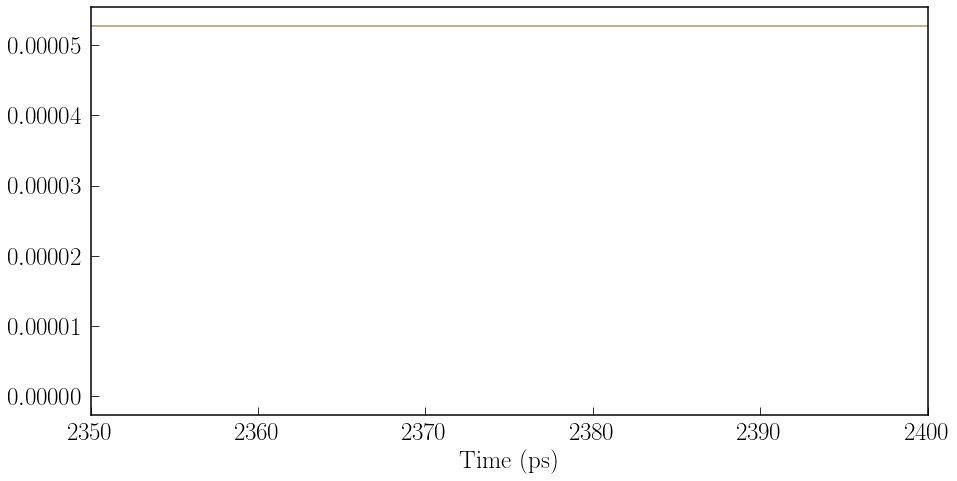

In [43]:
pl.plot(time_array, emitter_current_array, alpha = 0.5)
pl.plot(time_array, collector_current_array, alpha = 0.5)

#pl.plot(time_array, PC_input_current_array, alpha = 0.5)
#pl.plot(time_array, PC_output_current_array, alpha = 0.5)

pl.xlim([2350, 2400])

pl.xlabel(r'Time (ps)')

print (emitter_current_array[-1])
print (collector_current_array[-1])
